In [1]:
import math
import numpy as np

In [2]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.2f | grad %.2f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [31]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f'Value: data={self.data}'
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def tanh(self):
        x = self.data
        tanh = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(tanh, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - tanh**2) * out.grad
        self._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [32]:
a = Value(3, label='a')
b = Value(4, label='b')
c = Value(-11.0, label='c')

In [33]:
d = a*b; d.label='d'
f = d + c; f.label='f'
o = f.tanh();

In [34]:
o.backward()

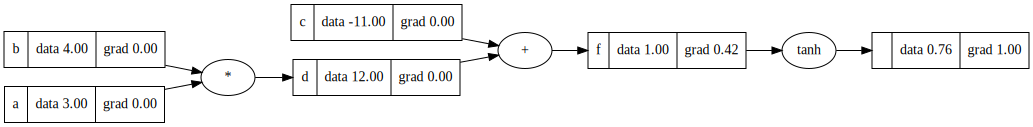

In [35]:
draw_dot(o)

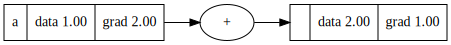

In [36]:
a = Value(1, label='a')
b = a + a; label='b'

b.backward()
draw_dot(b)

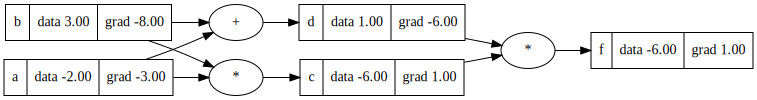

In [37]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
c = a * b; c.label = 'c'
d = a + b; d.label = 'd'
f = c * d; f.label = 'f'

f.backward()
draw_dot(f)